## P-set 5.


In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import qiskit_nature
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit.algorithms.optimizers import COBYLA
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Estimator
from qiskit_aer.primitives import Estimator as AerEstimator
qiskit_nature.settings.use_pauli_sum_op = False

Matplotlib is building the font cache; this may take a moment.


1. 80 points

Infer the ground state energy of $H_2$ for a series of interatomic distances $0.4 < d < 6$ (Bohr) and
plot the ground state energy as function of interatomic distances. (use Qiskit)

At what distance is the molecule most stable? (Answere in markdown cell)

# Mapper choice

In [2]:
molecule = MoleculeInfo(
    # Choose atoms and coordinates
    symbols= ["H","H"],
    coords=[[0.0, 0.0, 0.0],[0.0, 0.0, 0.735]],
    multiplicity=1,  # = 2*spin + 1
    charge=0,
    units=DistanceUnit.BOHR # other option is ANGSTROM 
)

driver = PySCFDriver.from_molecule(molecule)

# Get molecule properties
problem = driver.run()
num_particles = problem.num_particles
num_spatial_orbitals = problem.num_spatial_orbitals

p_mapper = ParityMapper(num_particles=num_particles)
p_qubit_op = p_mapper.map(problem.second_q_ops()[0])
print(p_qubit_op)

t_mapper = problem.get_tapered_mapper(p_mapper)
t_qubit_op = t_mapper.map(problem.second_q_ops()[0])
print(t_qubit_op)

SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-0.8515997 +0.j,  0.70148437+0.j, -0.70148437+0.j, -0.0129563 +0.j,
  0.16407112+0.j])
SparsePauliOp(['I', 'Z', 'X'],
              coeffs=[-0.8386434 +0.j, -1.40296874+0.j, -0.16407112+0.j])


## The Jordan-Wigner Mapping
The Jordan-Wigner mapping is the most straight-forward mapping with the simplest physical interpretation, because it maps the occupation of one spin-orbital to the occupation of one qubit.

## The Parity Mapping
The Parity mapping is the dual mapping to the Jordan-Wigner one, in the sense that it encodes the parity information locally on one qubit, whereas the occupation information is delocalized over all qubits.

## More advanced qubit reductions
It is also possible to perform more advanced qubit reductions, which are based on finding Z2 symmetries in the Hilbert space of the qubit. A requirement for this to be useful, is that you know in which symmetry-subspace you need to look for your actual solution of interest. This can be a bit tricky, but luckily the problem classes of Qiskit Nature provide you with a utility to automatically determine that correct subspace.

As you can see here, the H2 molecule is such a simple system that we can simulate it entirely on a single qubit!

In [3]:
# Convert the molecular configuration problem to an observable
def get_qubit_op(dist):
    # Define molecule
    molecule = MoleculeInfo(
        # Choose atoms and coordinates

        symbols= ["H","H"],
        coords=[[0.0, 0.0, 0.0],[0.0, 0.0, dist]],

        multiplicity=1,  # = 2*spin + 1
        charge=0,
        units=DistanceUnit.BOHR # other option is ANGSTROM 
    )
    driver = PySCFDriver.from_molecule(molecule)

    # Get molecule properties
    problem = driver.run()
    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals
    
    p_mapper = ParityMapper(num_particles=num_particles)
    
    #tapered mapper for smaller stuff :)
    mapper = problem.get_tapered_mapper(p_mapper)
    qubit_op = t_mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

# Ansatz choice

Aperantly USCCD is already the best Ansatz to use for this problem

In [4]:
# Define your ansatz
def get_ansatz(num_particles, num_spatial_orbitals, mapper):
    reference_state = HartreeFock(
        num_spatial_orbitals,
        num_particles,
        mapper
    )
    
    # choose an Ansatz and define it as "var_form"
    # see: https://qiskit.org/ecosystem/nature/apidocs/qiskit_nature.second_q.circuit.library.html
    var_form = UCCSD(
        num_spatial_orbitals = num_spatial_orbitals,
        num_particles = num_particles,
        qubit_mapper = mapper,
        initial_state = reference_state
    );
    
    # check properties of your ansatz

    print('\nAnsatz circuit properties:\n',
        f'  Detph: {var_form.decompose(reps=3).depth()}\n',
        f'  N-Qubits: {var_form.width()}\n',
        f'  Tunable Parameters: {var_form.num_parameters}')
    var_form.decompose(reps=3).draw('mpl')
    
    # --- Your code goes here
    return var_form

In [12]:
# Define a solver routine
def vqe_solver(qubit_op, ansatz, problem, estimator, optimizer=None):  
    if optimizer == None: 
        optimizer = COBYLA(maxiter=20)
    vqe = VQE(estimator,
              ansatz,
              optimizer,
              initial_point=[0] * ansatz.num_parameters,
    )    
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    return vqe_result

In [6]:
#Lmao Exact solver
def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result

In [7]:
# Set the backend
service = QiskitRuntimeService(channel='ibm_quantum')
sim_backend = service.get_backend('ibmq_qasm_simulator')
print(sim_backend)

<IBMBackend('ibmq_qasm_simulator')>


In [63]:
from tqdm import tqdm

# Evaluate the groundstate energy
# Define distances as "dist"

a_exact_energies = []
a_vqe_energies_noisy = []
a_vqe_times = []
a_full_execution_time = 0

distances = np.linspace(0.4, 6, 20)

with Session(service=service,backend=sim_backend) as session:
    estimator = Estimator(session=session) #noisy only, i dont care rn
    
    fst = time.time()
    
    # for every distance:
    for i, dist in enumerate(tqdm(distances, desc="Processing", unit="distance")):
        print(f"Starting iteration {i} with distance {dist}")
        # Prepare problem
        (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(dist)
        
        # calc exact result
        exact_calc = exact_solver(qubit_op, problem)
        exact_result = exact_calc.total_energies[0].real
        
        st = time.time()
    
        # Prepare VQE ansatz
        ansatz = get_ansatz(num_particles, num_spatial_orbitals, mapper)

        # Solve the problem using VQE
        vqe_result = vqe_solver(qubit_op, ansatz, problem, estimator)
        
        et = time.time()
        vqe_time = et - st
    
        print(
            f"\nInteratomic Distance: {np.round(dist, 2)} (Bohr)\n",
            f"Exact Result: {exact_result:.5f} (Hartree)\n",
            f"VQE Result: {vqe_result:.5f} (Hartree)\n",
            f"Took {vqe_time} seconds of your life"
        )
        
        a_exact_energies.append(exact_result)
        a_vqe_energies_noisy.append(vqe_result)
        a_vqe_times.append(vqe_time)
                
    fet = time.time()
    
a_full_execution_time = fet - fst    
print('Execution time:', a_full_execution_time, 'seconds')

print(distances, a_exact_energies, a_vqe_energies_noisy, a_vqe_times)

        

Processing:   0%|          | 0/20 [00:00<?, ?distance/s]

Starting iteration 0 with distance 0.4


base_primitive._run_primitive:INFO:2023-11-23 18:04:12,690: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}



Ansatz circuit properties:
   Detph: 1
   N-Qubits: 1
   Tunable Parameters: 1


base_primitive._run_primitive:INFO:2023-11-23 18:04:17,203: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}
base_primitive._run_primitive:INFO:2023-11-23 18:04:20,695: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_trans


Interatomic Distance: 0.4 (Bohr)
 Exact Result: 0.02496 (Hartree)
 VQE Result: 0.02482 (Hartree)
 Took 37.06192064285278 seconds of your life
Starting iteration 1 with distance 0.6947368421052631


base_primitive._run_primitive:INFO:2023-11-23 18:04:51,264: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}



Ansatz circuit properties:
   Detph: 1
   N-Qubits: 1
   Tunable Parameters: 1


base_primitive._run_primitive:INFO:2023-11-23 18:04:54,751: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}
base_primitive._run_primitive:INFO:2023-11-23 18:04:57,791: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_trans


Interatomic Distance: 0.69 (Bohr)
 Exact Result: -0.83908 (Hartree)
 VQE Result: -0.84543 (Hartree)
 Took 35.58649945259094 seconds of your life
Starting iteration 2 with distance 0.9894736842105263


base_primitive._run_primitive:INFO:2023-11-23 18:05:29,354: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}



Ansatz circuit properties:
   Detph: 1
   N-Qubits: 1
   Tunable Parameters: 1


base_primitive._run_primitive:INFO:2023-11-23 18:05:33,511: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}
base_primitive._run_primitive:INFO:2023-11-23 18:05:37,799: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_trans


Interatomic Distance: 0.99 (Bohr)
 Exact Result: -1.07487 (Hartree)
 VQE Result: -1.07732 (Hartree)
 Took 38.177141427993774 seconds of your life
Starting iteration 3 with distance 1.2842105263157895


base_primitive._run_primitive:INFO:2023-11-23 18:06:09,114: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}



Ansatz circuit properties:
   Detph: 1
   N-Qubits: 1
   Tunable Parameters: 1


base_primitive._run_primitive:INFO:2023-11-23 18:06:12,355: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}
base_primitive._run_primitive:INFO:2023-11-23 18:06:16,436: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_trans


Interatomic Distance: 1.28 (Bohr)
 Exact Result: -1.13437 (Hartree)
 VQE Result: -1.13770 (Hartree)
 Took 38.7369601726532 seconds of your life
Starting iteration 4 with distance 1.5789473684210527


base_primitive._run_primitive:INFO:2023-11-23 18:06:49,511: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}



Ansatz circuit properties:
   Detph: 1
   N-Qubits: 1
   Tunable Parameters: 1


base_primitive._run_primitive:INFO:2023-11-23 18:06:52,578: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}
base_primitive._run_primitive:INFO:2023-11-23 18:06:55,826: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_trans


Interatomic Distance: 1.58 (Bohr)
 Exact Result: -1.13027 (Hartree)
 VQE Result: -1.13520 (Hartree)
 Took 33.70278859138489 seconds of your life
Starting iteration 5 with distance 1.8736842105263158


base_primitive._run_primitive:INFO:2023-11-23 18:07:24,985: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}



Ansatz circuit properties:
   Detph: 1
   N-Qubits: 1
   Tunable Parameters: 1


base_primitive._run_primitive:INFO:2023-11-23 18:07:29,307: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}
base_primitive._run_primitive:INFO:2023-11-23 18:07:33,600: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_trans


Interatomic Distance: 1.87 (Bohr)
 Exact Result: -1.10293 (Hartree)
 VQE Result: -1.10475 (Hartree)
 Took 37.48955178260803 seconds of your life
Starting iteration 6 with distance 2.1684210526315786


base_primitive._run_primitive:INFO:2023-11-23 18:08:04,200: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}



Ansatz circuit properties:
   Detph: 1
   N-Qubits: 1
   Tunable Parameters: 1


base_primitive._run_primitive:INFO:2023-11-23 18:08:07,387: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}
base_primitive._run_primitive:INFO:2023-11-23 18:08:10,885: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_trans


Interatomic Distance: 2.17 (Bohr)
 Exact Result: -1.06850 (Hartree)
 VQE Result: -1.07089 (Hartree)
 Took 34.07236623764038 seconds of your life
Starting iteration 7 with distance 2.4631578947368418


base_primitive._run_primitive:INFO:2023-11-23 18:08:40,900: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}



Ansatz circuit properties:
   Detph: 1
   N-Qubits: 1
   Tunable Parameters: 1


base_primitive._run_primitive:INFO:2023-11-23 18:08:45,027: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}
base_primitive._run_primitive:INFO:2023-11-23 18:08:49,335: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_trans


Interatomic Distance: 2.46 (Bohr)
 Exact Result: -1.03447 (Hartree)
 VQE Result: -1.04047 (Hartree)
 Took 36.58967351913452 seconds of your life
Starting iteration 8 with distance 2.757894736842105


base_primitive._run_primitive:INFO:2023-11-23 18:09:19,365: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}



Ansatz circuit properties:
   Detph: 1
   N-Qubits: 1
   Tunable Parameters: 1


base_primitive._run_primitive:INFO:2023-11-23 18:09:22,423: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}
base_primitive._run_primitive:INFO:2023-11-23 18:09:25,587: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_trans


Interatomic Distance: 2.76 (Bohr)
 Exact Result: -1.00487 (Hartree)
 VQE Result: -1.00502 (Hartree)
 Took 34.52556800842285 seconds of your life
Starting iteration 9 with distance 3.052631578947368


base_primitive._run_primitive:INFO:2023-11-23 18:09:55,490: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}



Ansatz circuit properties:
   Detph: 1
   N-Qubits: 1
   Tunable Parameters: 1


base_primitive._run_primitive:INFO:2023-11-23 18:09:58,715: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}
base_primitive._run_primitive:INFO:2023-11-23 18:10:01,686: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_trans


Interatomic Distance: 3.05 (Bohr)
 Exact Result: -0.98145 (Hartree)
 VQE Result: -0.98027 (Hartree)
 Took 35.18661427497864 seconds of your life
Starting iteration 10 with distance 3.3473684210526313


base_primitive._run_primitive:INFO:2023-11-23 18:10:32,231: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}



Ansatz circuit properties:
   Detph: 1
   N-Qubits: 1
   Tunable Parameters: 1


base_primitive._run_primitive:INFO:2023-11-23 18:10:35,543: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}
base_primitive._run_primitive:INFO:2023-11-23 18:10:38,751: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_trans


Interatomic Distance: 3.35 (Bohr)
 Exact Result: -0.96434 (Hartree)
 VQE Result: -0.96572 (Hartree)
 Took 37.26954770088196 seconds of your life
Starting iteration 11 with distance 3.6421052631578945


base_primitive._run_primitive:INFO:2023-11-23 18:11:11,324: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}



Ansatz circuit properties:
   Detph: 1
   N-Qubits: 1
   Tunable Parameters: 1


base_primitive._run_primitive:INFO:2023-11-23 18:11:14,427: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}
base_primitive._run_primitive:INFO:2023-11-23 18:11:18,643: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_trans


Interatomic Distance: 6.0 (Bohr)
 Exact Result: -0.93340 (Hartree)
 VQE Result: -0.93333 (Hartree)
 Took 35.73636198043823 seconds of your life
Execution time: 764.7017238140106 seconds
[0.4        0.69473684 0.98947368 1.28421053 1.57894737 1.87368421
 2.16842105 2.46315789 2.75789474 3.05263158 3.34736842 3.64210526
 3.93684211 4.23157895 4.52631579 4.82105263 5.11578947 5.41052632
 5.70526316 6.        ] [0.0249581832879624, -0.8390832715782475, -1.0748696125169281, -1.134368012609979, -1.130272866324794, -1.1029324296789436, -1.0684972144036395, -1.0344717952476732, -1.004866896090898, -0.9814515937168646, -0.9643374432393388, -0.9526206024437465, -0.9450020830165181, -0.9402323187803365, -0.9373228185493983, -0.9355792006596787, -0.9345481593637148, -0.9339460095099625, -0.9335990627322983, -0.9334021769910893] [0.024819885119670815, -0.8454324978799868, -1.0773156209947603, -1.137698885202619, -1.1352014472752319, -1.1047456691129023, -1.070887643780024, -1.0404684570914584, -1.

^^ that error is ignore.

    Distance (Bohr)  Exact Energy (Hartree)  VQE Energy Noisy (Hartree)  \
0          0.400000                0.024958                    0.024820   
1          0.694737               -0.839083                   -0.845432   
2          0.989474               -1.074870                   -1.077316   
3          1.284211               -1.134368                   -1.137699   
4          1.578947               -1.130273                   -1.135201   
5          1.873684               -1.102932                   -1.104746   
6          2.168421               -1.068497                   -1.070888   
7          2.463158               -1.034472                   -1.040468   
8          2.757895               -1.004867                   -1.005025   
9          3.052632               -0.981452                   -0.980268   
10         3.347368               -0.964337                   -0.965725   
11         3.642105               -0.952621                   -0.952598   
12         3.936842      

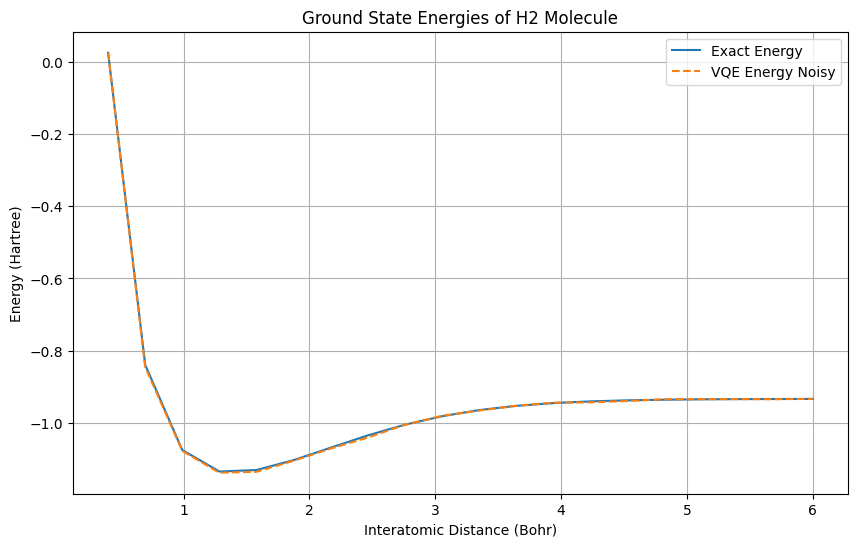

In [64]:
# Create a DataFrame
data = {
    'Distance (Bohr)': distances,
    'Exact Energy (Hartree)': a_exact_energies,
    'VQE Energy Noisy (Hartree)': a_vqe_energies_noisy,
    'VQE execution time (Seconds)': a_vqe_times
}
df = pd.DataFrame(data)

print(df)


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['Distance (Bohr)'], df['Exact Energy (Hartree)'], label='Exact Energy')
plt.plot(df['Distance (Bohr)'], df['VQE Energy Noisy (Hartree)'], label='VQE Energy Noisy', linestyle='--')
plt.xlabel('Interatomic Distance (Bohr)')
plt.ylabel('Energy (Hartree)')
plt.title('Ground State Energies of H2 Molecule')
plt.legend()
plt.grid(True)
plt.show()

with my low sample size of 20 the distance its most stable at is at 1.284211 Bohr.

2. 20 points

Try to execute 1. on a real Quantum Computer. Note that IBM Quantum grants free access to 5 and 7 qubit systems. This might confine your Ansatz.

Hint: Before executin your code check which system is least busy.

I don't think thats correct anymore? as of writing this there are more 7 qubit systems and one 127 qbit for "free". HOWEVER only for 10 minutes each. I already ran out of credits on 2 accounts. lmao 

## Changes to mittigate this:
* do less distances around the minimum fom last time
* lower the optimiser iterations drastically

In [16]:
!pip install tqdm


[notice] A new release of pip available: 23.1.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [17]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
print(backend, backend.name)

<IBMBackend('ibm_nairobi')> ibm_nairobi


In queue for an hour ☠️☠️☠️

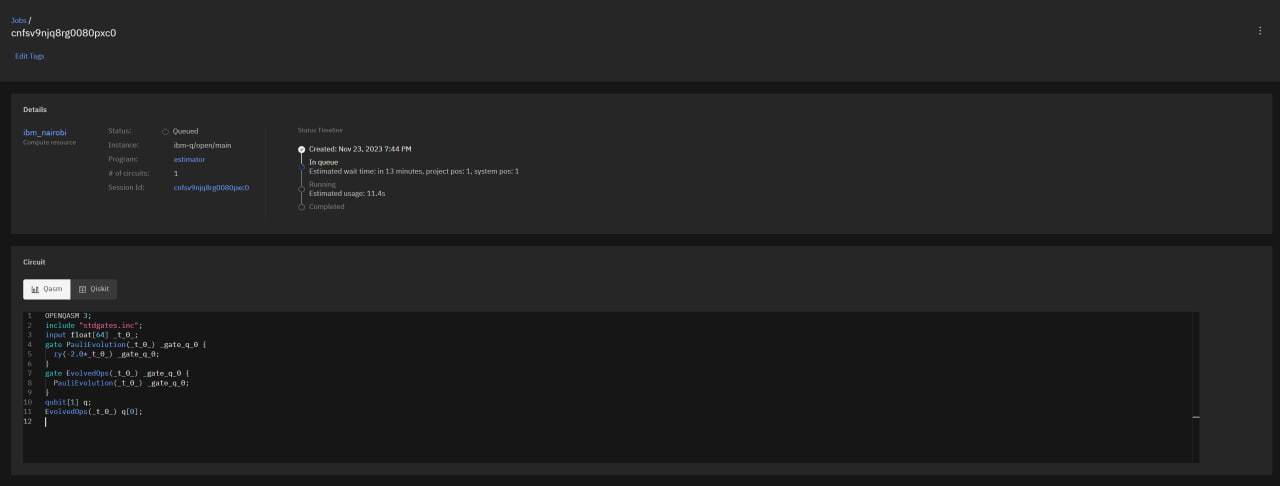

In [18]:
from tqdm import tqdm

# Evaluate the groundstate energy
# Define distances as "dist"

q_exact_energies = []
q_vqe_energies_noisy = []
q_vqe_times = []
q_full_execution_time = 0

distances = np.linspace(0.7, 2.1, 5)

with Session(service=service,backend=backend) as session:
    estimator = Estimator(session=session) #noisy only, i dont care rn
    
    fst = time.time()
    
    # for every distance:
    for i, dist in enumerate(tqdm(distances, desc="Processing", unit="distance")):
        print(f"Starting iteration {i} with distance {dist}")
        # Prepare problem
        (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(dist)
        
        # calc exact result
        exact_calc = exact_solver(qubit_op, problem)
        exact_result = exact_calc.total_energies[0].real
        
        st = time.time()
    
        # Prepare VQE ansatz
        ansatz = get_ansatz(num_particles, num_spatial_orbitals, mapper)

        # Solve the problem using VQE
        vqe_result = vqe_solver(qubit_op, ansatz, problem, estimator)
        
        et = time.time()
        vqe_time = et - st
    
        print(
            f"\nInteratomic Distance: {np.round(dist, 2)} (Bohr)\n",
            f"Exact Result: {exact_result:.5f} (Hartree)\n",
            f"VQE Result: {vqe_result:.5f} (Hartree)\n",
            f"Took {vqe_time} seconds of your life\n"
        )
        
        q_exact_energies.append(exact_result)
        q_vqe_energies_noisy.append(vqe_result)
        q_vqe_times.append(vqe_time)
                
    fet = time.time()
    
q_full_execution_time = fet - fst    
print('Execution time:', q_full_execution_time, 'seconds\n')
        

Processing:   0%|          | 0/5 [00:00<?, ?distance/s]

Starting iteration 0 with distance 0.7


base_primitive._run_primitive:INFO:2023-11-23 19:28:39,106: Submitting job using options {'optimization_level': 3, 'resilience_level': 1, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 3}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 1}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}



Ansatz circuit properties:
   Detph: 1
   N-Qubits: 1
   Tunable Parameters: 1


Processing:  20%|██        | 1/5 [02:19<09:17, 139.30s/distance]


Interatomic Distance: 0.7 (Bohr)
 Exact Result: -0.84633 (Hartree)
 VQE Result: -0.83152 (Hartree)
 Took 136.6571867465973 seconds of your life

Starting iteration 1 with distance 1.05


base_primitive._run_primitive:INFO:2023-11-23 19:30:57,877: Submitting job using options {'optimization_level': 3, 'resilience_level': 1, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 3}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 1}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}



Ansatz circuit properties:
   Detph: 1
   N-Qubits: 1
   Tunable Parameters: 1


Processing:  40%|████      | 2/5 [02:57<03:59, 79.69s/distance] 


Interatomic Distance: 1.05 (Bohr)
 Exact Result: -1.09591 (Hartree)
 VQE Result: -1.06354 (Hartree)
 Took 35.75572228431702 seconds of your life

Starting iteration 2 with distance 1.4


base_primitive._run_primitive:INFO:2023-11-23 19:31:35,525: Submitting job using options {'optimization_level': 3, 'resilience_level': 1, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 3}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 1}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}



Ansatz circuit properties:
   Detph: 1
   N-Qubits: 1
   Tunable Parameters: 1


Processing:  60%|██████    | 3/5 [03:35<02:01, 60.67s/distance]


Interatomic Distance: 1.4 (Bohr)
 Exact Result: -1.13728 (Hartree)
 VQE Result: -1.11363 (Hartree)
 Took 36.23150444030762 seconds of your life

Starting iteration 3 with distance 1.75


base_primitive._run_primitive:INFO:2023-11-23 19:32:13,739: Submitting job using options {'optimization_level': 3, 'resilience_level': 1, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 3}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 1}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}



Ansatz circuit properties:
   Detph: 1
   N-Qubits: 1
   Tunable Parameters: 1


Processing:  80%|████████  | 4/5 [04:13<00:51, 51.77s/distance]


Interatomic Distance: 1.75 (Bohr)
 Exact Result: -1.11590 (Hartree)
 VQE Result: -1.07763 (Hartree)
 Took 36.04918122291565 seconds of your life

Starting iteration 4 with distance 2.1


base_primitive._run_primitive:INFO:2023-11-23 19:32:52,153: Submitting job using options {'optimization_level': 3, 'resilience_level': 1, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 3}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 1}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}



Ansatz circuit properties:
   Detph: 1
   N-Qubits: 1
   Tunable Parameters: 1


Processing: 100%|██████████| 5/5 [04:51<00:00, 58.33s/distance]


Interatomic Distance: 2.1 (Bohr)
 Exact Result: -1.07666 (Hartree)
 VQE Result: -1.02541 (Hartree)
 Took 35.906134843826294 seconds of your life

Execution time: 291.6721477508545 seconds



I'm really sorry I had to turn the optimiser wayyy down! I put maxiter = 1! This means the VQE results are WAYYYYYYYYYYYYYYYY off sometimes, but there wouldnt be any other way of making it work. at 11s per iteration I would fill up my montly allowance in no time!

   Distance (Bohr)  Exact Energy (Hartree)  VQE Energy Noisy (Hartree)  \
0             0.70               -0.846326                   -0.831517   
1             1.05               -1.095905                   -1.063537   
2             1.40               -1.137276                   -1.113629   
3             1.75               -1.115900                   -1.077628   
4             2.10               -1.076656                   -1.025407   

   VQE execution time (Seconds)  
0                    136.657187  
1                     35.755722  
2                     36.231504  
3                     36.049181  
4                     35.906135  


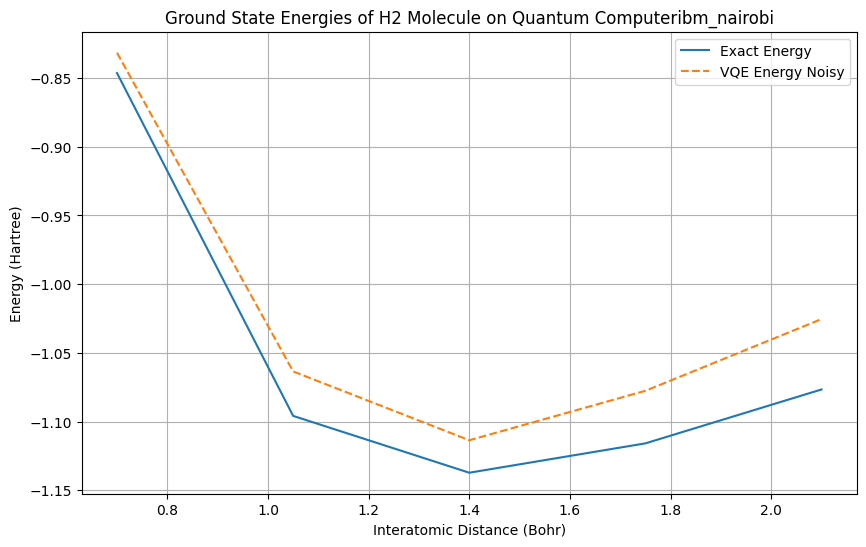

In [19]:
# Create a DataFrame
data = {
    'Distance (Bohr)': distances,
    'Exact Energy (Hartree)': q_exact_energies,
    'VQE Energy Noisy (Hartree)': q_vqe_energies_noisy,
    'VQE execution time (Seconds)': q_vqe_times
}
df = pd.DataFrame(data)

print(df)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['Distance (Bohr)'], df['Exact Energy (Hartree)'], label='Exact Energy')
plt.plot(df['Distance (Bohr)'], df['VQE Energy Noisy (Hartree)'], label='VQE Energy Noisy', linestyle='--')
plt.xlabel('Interatomic Distance (Bohr)')
plt.ylabel('Energy (Hartree)')
plt.title('Ground State Energies of H2 Molecule on Quantum Computer' + backend.name)
plt.legend()
plt.grid(True)
plt.show()

Minimum 1.4 Bohr at -1.113629 Hartree